In [4]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from tsaug import Drift, AddNoise, TimeWarp
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm
from pytz import timezone
import json
import os

In [5]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60
IMAGE_HEIGHT = 370 # height size of standard spectrogram (matplotlib)
NFFT = 255 # 1 window in spectrogram is derived from NFFT datapoints
NOVERLAP = 128 # window hop in spectrogram

In [6]:
# User change:
TRANSFORMER_IMPUTATION = True # whether to use transformer imputation or linear interpolation

NORMALIZE_SUBJECTS = True # whether to normalize all variables subject-wise (to counteract high subject variability)

SEGMENT_LENGTH = 497 # width of one segment [pixels] (full day data is 370x497 pixels)
OVERLAP = 0.75 # of neighbouring segments [%]
FILTER_THRESHOLD = 0.5 # discard segment if contains >FILTER_THRESHOLD aritificial data [%]
AUGMENTATION_SIZE = 0.5 # size of additional augmented datapoints relative to full dataset [%]
AUGMENTATION_PROB = 0.25 # probability of single augmentation

TIME_WARP_MIN, TIME_WARP_MAX = 1.01, 3.0 # maximal ratio of max/min speed in the warped time line
NOISE_MIN, NOISE_MAX = 0.01, 0.02 # add random noise up to MIN-MAX
MAGNITUDE_WARP_MIN, MAGNITUDE_WARP_MAX = 0.01, 0.05 # random drift the signal up to MIN-MA
SCALING_STD = 0.05 # scale time-series by N(1, SCALING_STD)

In [20]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def plotter_spec(day, dat, NFFT=256, noverlap=128):
    """
    Plots spectrograms of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.specgram(time_series, Fs=SAMPLING_RATE, NFFT=NFFT, noverlap=NOVERLAP)

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['indianred', 'lightgreen'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def spectrogram_as_array(time_series, iteration=1):
    """
    Retrieves numerical data from spectrogram
    """
    # for stability
    time_series += np.random.normal(0.0, 1e-15)

    # calculate spectrogram
    fig = plt.figure()
    fig.add_subplot(111)
    plt.specgram(time_series,
                 Fs=SAMPLING_RATE,
                 NFFT=NFFT,
                 noverlap=NOVERLAP)
    plt.axis('off') # removes everything except content of plot

    # need to draw plot to create spectrogram
    fig.canvas.draw()

    # save pixels in numpy array
    numerical = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    numerical = numerical.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close() # prevent showing plot

    # remove white padding around spectrogram image
    height, width, channels = numerical.shape
    all_white_rows = np.where(np.sum(numerical[:, :, 0], axis=1) == 255 * width)[0]
    all_white_cols = np.where(np.sum(numerical[:, :, 0], axis=0) == 255 * height)[0]

    start_row, end_row = max(all_white_rows[all_white_rows - np.mean(all_white_rows) < 0]), \
                         min(all_white_rows[all_white_rows - np.mean(all_white_rows) > 0])
    start_col, end_col = max(all_white_cols[all_white_cols - np.mean(all_white_cols) < 0]), \
                         min(all_white_cols[all_white_cols - np.mean(all_white_cols) > 0])

    numerical = numerical[start_row:end_row, start_col:end_col, :]
    return numerical

def save_spectrogram(spectrogram, name):
    """
    Saves spectrogram as png
    """
    plt.figure()
    plt.imshow(spectrogram)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./Output/{name}.png')
    plt.close() # prevent showing plot

def segmentor(image):
    """
    Segments images into subimages (along width axis)
    """
    height, width, channels = image.shape
    segments = []
    delta = int((1 - OVERLAP) * SEGMENT_LENGTH) # distance between two windows

    start, end = 0, SEGMENT_LENGTH
    while True:
        # check if building one more segment is possible
        if end > width - 1: # last pixel column is image[:, width - 1, :]
            break
        else:
            # possible to build segment
            segment = image[:, start:end, :]
            segments.append(segment)

        # move window further
        start += delta
        end += delta

    return segments

def plot_segments(image):
    """
    Plots image with visible segmentations
    """
    segments = segmentor(image)

    plt.figure()
    n = len(segments)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(segments[i])
        plt.xticks([]), plt.yticks([])

def tz_diff(date, tz1, tz2):
    """
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    """
    tz1 = 'CET' if tz1 == 'CEST' else tz1 # CEST is just summertime CET
    tz2 = 'CET' if tz2 == 'CEST' else tz2 # CEST is just summertime CET

    date = pd.to_datetime(date)
    tz1, tz2 = timezone(tz1), timezone(tz2)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds / 3600

# Import data

In [21]:
# file path to data folder
path = './Output'

In [22]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

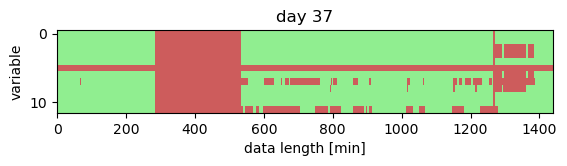

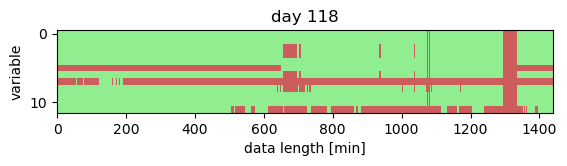

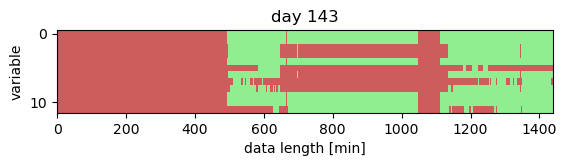

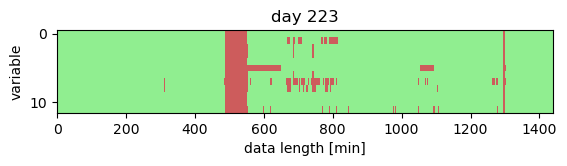

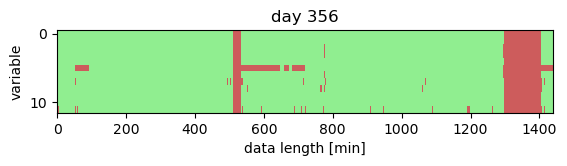

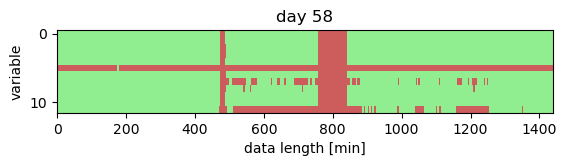

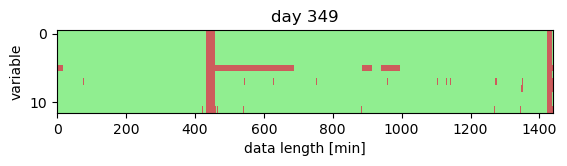

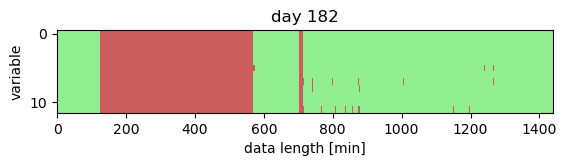

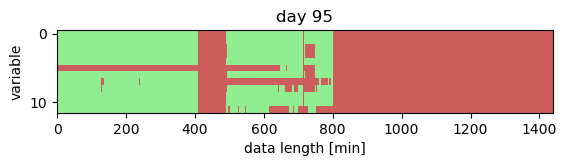

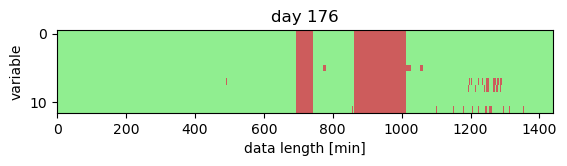

In [23]:
# visualize missing data (red: missing data, green: data)
N = 10
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

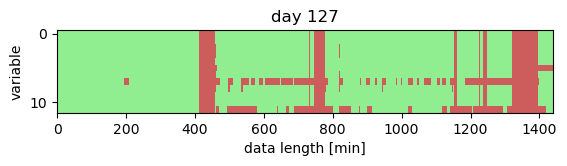

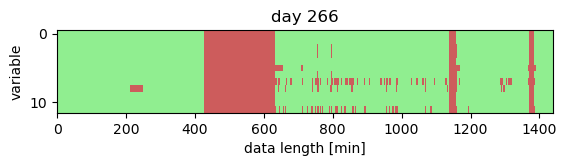

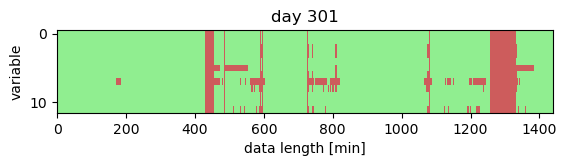

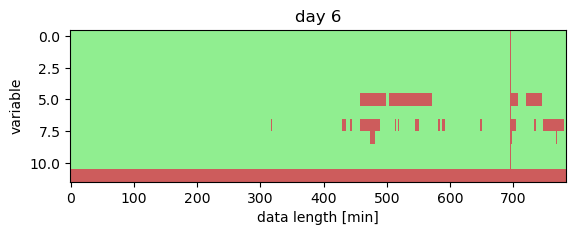

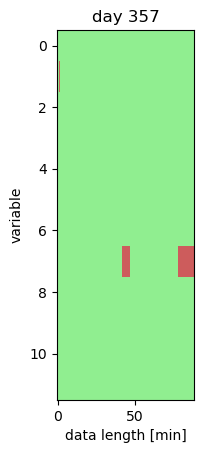

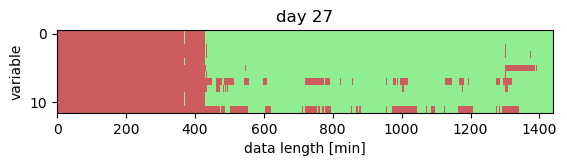

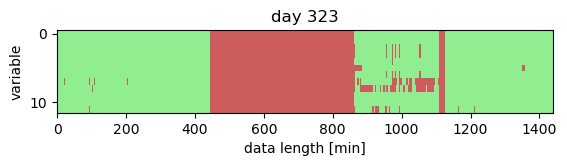

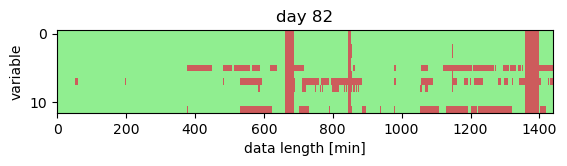

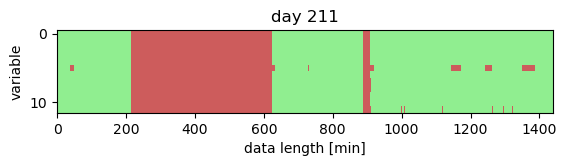

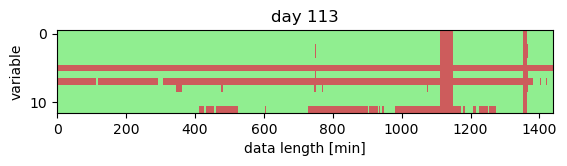

In [46]:
# visualize missing data (red: missing data, green: data)
N = 10
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

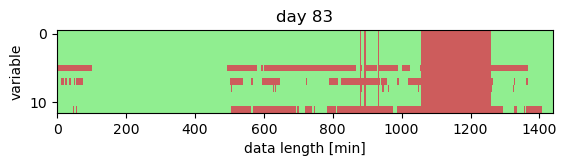

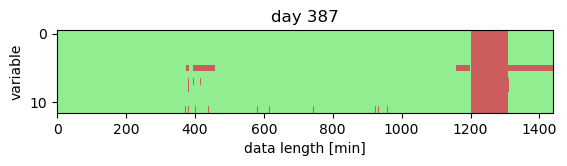

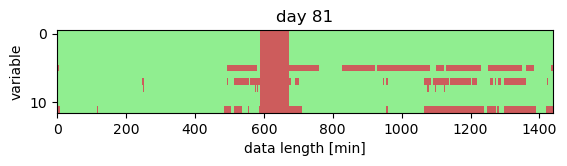

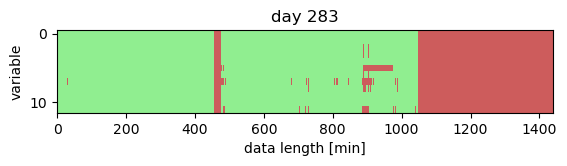

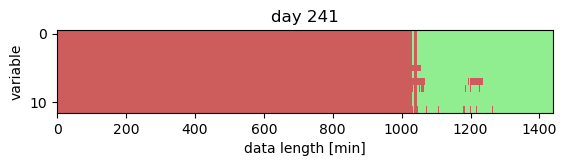

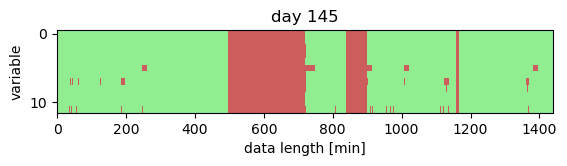

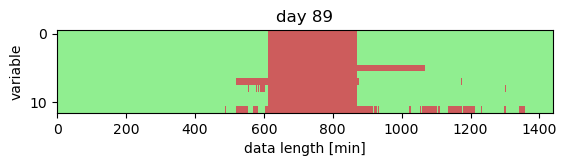

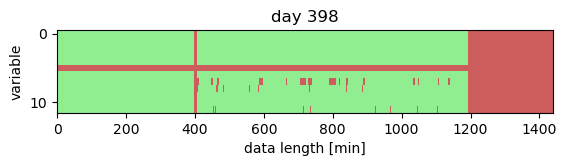

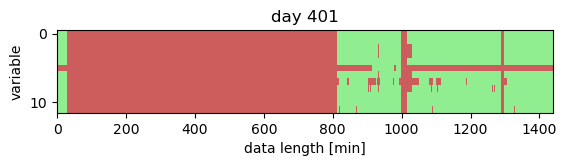

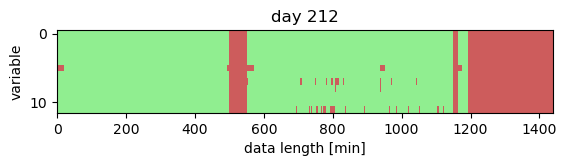

In [54]:
# visualize missing data (red: missing data, green: data)
N = 10
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

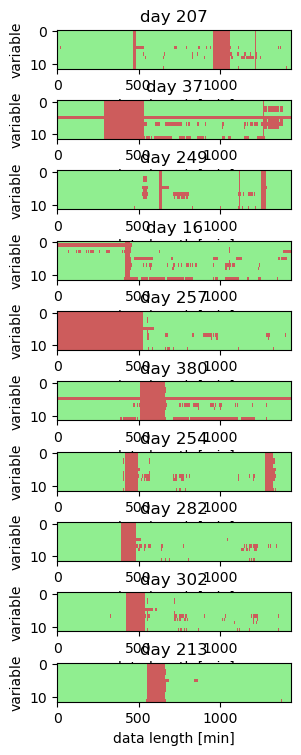

In [41]:
plt.figure()
plt.subplots_adjust(left=0.8,
                    bottom=0.1,
                    right=20.0,
                    top=1.5,
                    wspace=0.8,
                    hspace=0.8)
for j, day in enumerate(days):
    length = get_time_series(data, 'ActivityCounts', day).shape[0]
    n_variables = len(VARIABLES)
    na_matrix = np.zeros((n_variables, length))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(data, variable, day)

        na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
        na_matrix[i, :] = na_data

    # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
    na_matrix[1, 1] = 0.0
    na_matrix[2, 1] = 1.0

    # plot
    cmap = matplotlib.colors.ListedColormap(['indianred', 'lightgreen'])
    plt.subplot(len(days), 1, j + 1)
    plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
    plt.title(f'day {day}')
    plt.xlabel('data length [min]')
    plt.ylabel('variable')

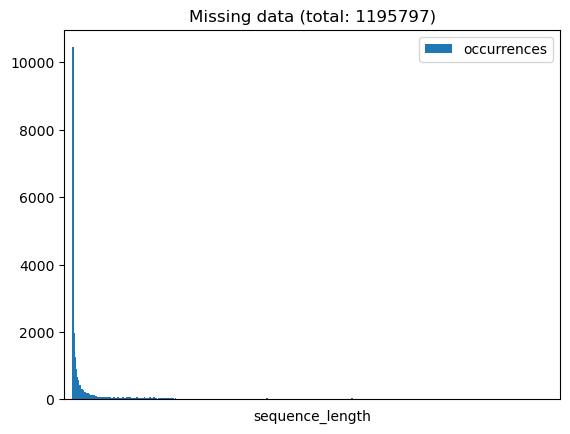

In [56]:
temp = na_sequence_lengths(data)

(-10.0, 564.0)

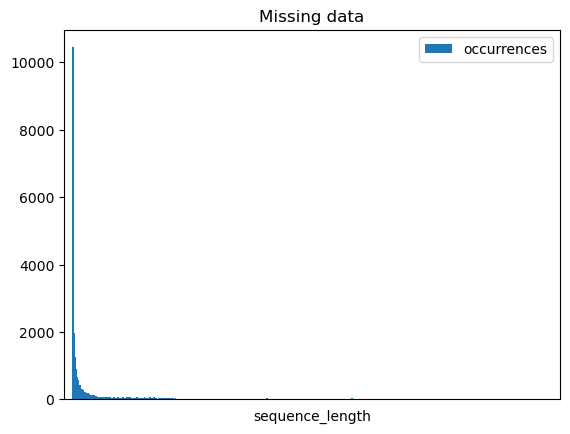

In [57]:
temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data')
plt.xticks([])
plt.xlim([-10, temp.shape[0]])

In [58]:
temp

,sequence_length,occurrences
0,1,10442
1,2,4282
2,3,1974
3,4,1273
4,5,891
...,...,...
559,1165,1
560,1175,1
561,1270,11
562,1354,12


(-10.0, 564.0)

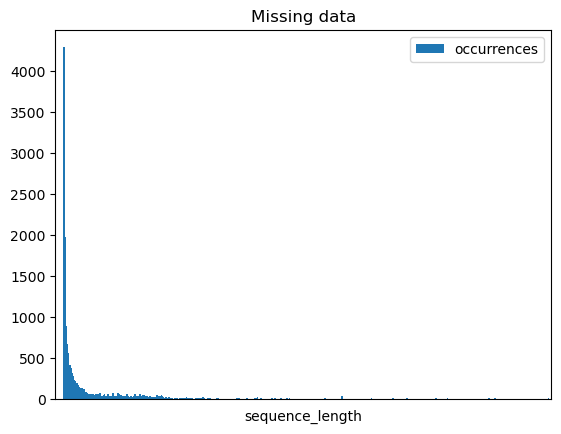

In [61]:
temp.iloc[1:].plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data')
plt.xticks([])
plt.xlim([-10, temp.shape[0]])

(-10.0, 564.0)

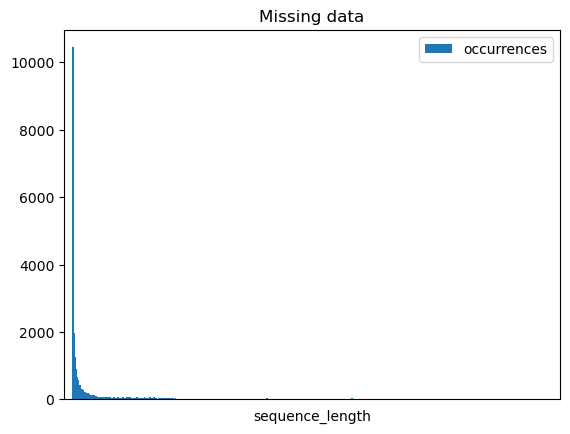

In [63]:
temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data')
plt.xticks([])
plt.xlim([-10, temp.shape[0]])

In [76]:
temp2 = temp.copy()
temp2['occurrences'] = np.log(temp2['occurrences'])

(-10.0, 564.0)

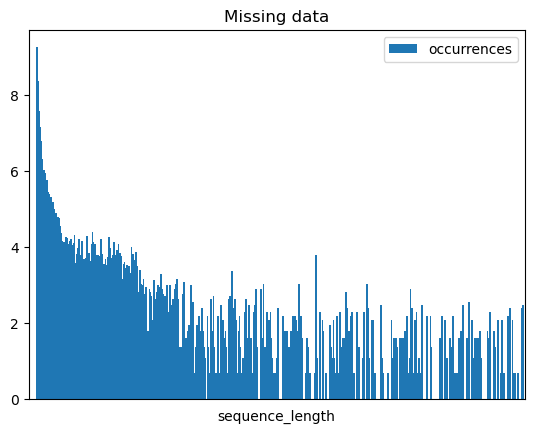

In [77]:
temp2.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data')
plt.xticks([])
plt.xlim([-10, temp.shape[0]])

In [79]:
n_days, n_cols = data.shape

total_missing_values = 0
na_sequences_data = []
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)

        na_sequences = []
        na_seq = 0
        for datapoint in time_series:
            if not np.isnan(datapoint):
                if na_seq > 0:
                    na_sequences.append(na_seq)
                    total_missing_values += na_seq
                    na_seq = 0
            else:
                # datapoint is NA
                na_seq += 1
        na_sequences_data += na_sequences


In [80]:
temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])

In [81]:
temp

,n
0,1
1,1
2,1
3,1
4,5
...,...
30853,66
30854,1
30855,2
30856,137


In [88]:
temp.plot.bar()

<AxesSubplot:>

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000016DEDA17B80> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000016DEDA179D0> (for post_execute):



KeyboardInterrupt



array([[<AxesSubplot:title={'center':'n'}>]], dtype=object)

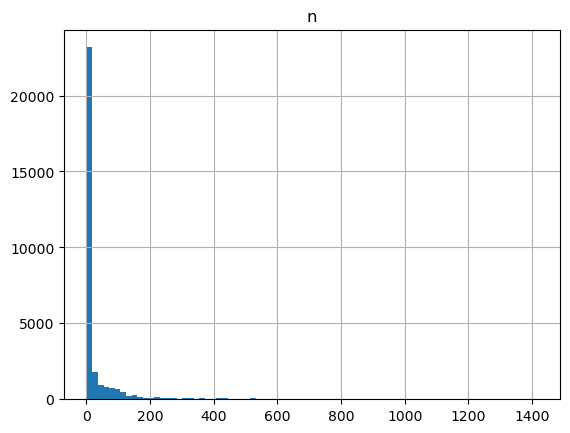

In [96]:
temp.hist(bins=80)

In [ ]:
# show numerical distribution of NA sequence lengths
query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
temp = sqldf(query)

# plot distribution of NA sequence lengths
temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
plt.xticks([])
plt.xlim([-10, temp.shape[0]])